In [1]:
from copy import deepcopy 

import numpy as np 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

from SmithZero import D2torchEngine

In [2]:
torch.manual_seed(42)

### Data Preparation 

In [3]:
from torchvision.datasets import CIFAR10 
import torchvision.transforms as T


# === data transformation === # 
train_T = T.Compose([   T.RandomCrop(32, padding=4),
                        T.RandomHorizontalFlip(), 
                        T.ToTensor(), 
                        T.Normalize(mean= (0.4914, 0.4822, 0.4465),
                                    std=(0.2023, 0.1994, 0.2010)),
                    ])

test_T = T.Compose([T.ToTensor(),
                    T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                std=(0.2023, 0.1994, 0.2010))
                    ])                  


# === download dataset object === # 
train_data = CIFAR10 (  root="./dataset/train",
                        train=True,
                        download=True,
                        transform=train_T )

test_data = CIFAR10 (   root="./dataset/test",
                        train=False,
                        download=True, 
                        transform=test_T )  

Files already downloaded and verified
Files already downloaded and verified


### Data Batching 

In [4]:
from torch.utils.data import DataLoader

trainloader = DataLoader(train_data,
                        batch_size=124,
                        shuffle=True, 
                        num_workers=4 
                        )

testloader = DataLoader(test_data,
                        batch_size=124,
                        num_workers=4
                        )

### Model Design 

In [5]:
class LeNet(nn.Module):
    def __init__(self, in_channels=3, n_class=10, p=0.5):
        super(LeNet, self).__init__()
        self.p = p # probability for DropOut layer 
        
        # === Create the convolution layers === # 
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, padding=2)
        self.c3 = nn.Conv2d(6, 16, 5) 
        self.c5 = nn.Conv2d(16, 120, 5) 

        # === Create the linear layers === # 
        self.f6 = nn.Linear(in_features=480, out_features=84)
        self.output = nn.Linear(in_features=84, out_features=n_class)

        # === Create dropout layers === # 
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # === block1 === # 
        x = self.c1(x)
        x = F.relu(x) 
        x = F.max_pool2d(x, kernel_size=2)
        # === block2 === # 
        x = self.c3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # === block3 === # 
        x = self.c5(x)
        x = F.relu(x)
        # ==== flattening === #
        x = nn.Flatten()(x)
        return x 

    def classifier(self, x): 
        # === hidden layler === # 
        if self.p > 0: 
            x = self.drop(x)        
        x = self.f6(x)
        x = F.relu(x)

        # === output layer === # 
        if self.p > 0 :
            x = self.drop(x)
        x = self.output(x)
        return x 
    
    def forward(self, x):
        x = self.featurizer(x) # return (1, 480)
        x = self.classifier(x) # return (1, 10)
        return x 

## Finding Learning Rates(LR) - ([ref](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/Chapter06.ipynb))
* how to __change the learning rate__ of an optimzier?
* a.k.a., ```LR range test```

In [6]:
from torch.optim.lr_scheduler import LambdaLR

In [ ]:
# === Higher-order Learning Rate Function === # 

def lr_func(start_lr, end_lr, num_iter, step_mode='exp'):

    if step_mode == 'linear': 
        factor = (end_lr / start_lr - 1) / num_iter
        def lr_fn(iteration):
            return 1 + iteration * factor
    
    elif step_mode == 'exp':
        factor = (np.log(end_lr) - np.log(start_lr)) / num_iter

        def lr_fn(iteration):
            return np.exp(factor)**iteration
    
    return lr_fn

In [ ]:
start_lr = 1e-3
end_lr = 1e-1
num_iter = 50

lr_scheduler = lr_func(start_lr, end_lr, num_iter, step_mode='exp')


### Model Configuration (```LambdaLR``` usage)

In [ ]:
model = LeNet(in_channels=3, n_class=10, p=0.5)

loss_fn = nn.CrossEntropyLoss(reduction='mean') 
optimizer = optim.Adam( model.parameters(), # (!) be sure to pass in the model.parameters() 
                        lr=start_lr, 
                    ) 
scheduler = LambdaLR(optimizer, lr_lambda=lr_scheduler)                     

In [ ]:
optimizer.state_dict()

In [ ]:
scheduler.state_dict()

In [ ]:
scheduler.get_last_lr()

In [ ]:
def lr_range_test(self, dataloader, end_lr, num_iter=100, step_mode='exp', alpha=5e-2, ax=None):

    previous_states = { 'model': deepcopy(self.model.state_dict()), 
                        'optimizer': deepcopy(self.optimizer.state_dict())
                        }

    # === Retrieves the learning rate set in the optimizer
    start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

    # === Builds a custom LR function 
    lr_fn = lr_func(start_lr, end_lr, num_iter) 

    # === Builds corresponding scheduler 
    scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn) 

    # === Tracking results and iterations 
    tracking = {'loss': [], 'lr':[]} 
    iteration = 0 

    while (iteration < num_iter):
        for inputs, labels in dataloader: 
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            yhat = self.model(inputs)
            loss = self.loss_fn(yhat, labels) 

            loss.backward() 

            # === Keep track of the losses and the learning_rate 
            tracking['lr'].append(scheduler.get_last_lr()[0])

            if iteration == 0: # start-point 
                tracking['loss'].append(loss.item())

            else: 
                previous_loss = tracking['loss'][-1]
                smoothed_loss = alpha * loss.item() + (1-alpha) * previous_loss
                tracking['loss'].append(smoothed_loss)
            
            iteration += 1 
            
            # When the number of iterations reached
            if iteration == num_iter: 
                break 

            # === Update 
            self.optimizer.step() 
            scheduler.step() 
            self.optimizer.zero_grad()

    # === Restores the original states 
    self.model.load_state_dict(previous_states['model'])
    self.optimizer.load_state_dict(previous_states['optimizer'])


    # === Visualization
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    else: 
        fig = ax.get_figure()

    ax.plot(tracking['lr'], tracking['loss']) 

    if step_mode == 'exp': 
        ax.set_xscale('log') 
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Loss')
    fig.tight_layout()
    return tracking, fig 

# add attribute
setattr(D2torchEngine, 'lr_range_test', lr_range_test)    

### Model Configuration

In [ ]:
AgentDL = D2torchEngine(model, loss_fn, optimizer)  # init. your deep learning engine 


# === Finding a good init. learning_rate
tracking, fig = AgentDL.lr_range_test(trainloader, end_lr=1e-1, num_iter=100)

In [ ]:
idx = np.argmin(np.array(tracking['loss']))

print(f"min_loss: {min(tracking['loss']):.3f} @ idx={idx}")
print(f"LR: {tracking['lr'][idx]:.3f}")

Before training, LR=0.018 shows the minimum loss value. <br/>
So, I'm gonna set LR as 5e-3 around 18e-3.

### Reset the optimizer

In [ ]:
def set_optimizer(self, optimizer): 
    self.optimizer = optimizer

# add attribute 
setattr(D2torchEngine, 'set_optimizer', set_optimizer)

In [ ]:
new_optimizer = optim.Adam( model.parameters(), # (!) be sure to pass in the model.parameters() 
                        lr=5e-3, 
                    ) 

AgentDL.set_optimizer(new_optimizer)                    
AgentDL.set_loaders(trainloader, testloader)

### Model Training

In [ ]:
# Run trianing 
AgentDL.train(n_epochs=50, seed=42)

In [ ]:
fig = AgentDL.plot_losses()

### LRFinder ★★★★
* ```lr_range_test``` defined above is fairly basic.
* For more useful usage, employ ```torch_lr_finder```.

In [ ]:
from torch_lr_finder import LRFinder

In [ ]:
new_model = LeNet(in_channels=3, n_class=10, p=0.5)
new_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

lr_finder = LRFinder(new_model, new_optimizer,new_loss_fn, device=device)
lr_finder.range_test(trainloader, end_lr=1e-1, num_iter=100)
lr_finder.plot(ax=ax, log_lr=True)

fig.tight_layout()
lr_finder.reset()

## Adaptive Learning Rate 

※ check p.513 to study more about ```Adaptive Learning Rate```

## Learning Rate Schedulers 
* dynamic ```LR change``` during training time 
* instead of ```Adaptive Learning Rate```

In [7]:
from torch.optim.lr_scheduler import (StepLR, ReduceLROnPlateau, MultiStepLR, 
                                        ExponentialLR, CosineAnnealingLR)

In [8]:
# === scheduler test === # 
dummy_model = LeNet(in_channels=3, n_class=10, p=0.5)
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=1e-2)
dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=1e-1) 

In [9]:
for epoch in range(4): 
    print(dummy_scheduler.get_last_lr())

    dummy_optimizer.step() # update optimizer 
    dummy_scheduler.step() # update scheduler
    
    dummy_optimizer.zero_grad()

[0.01]
[0.01]
[0.001]
[0.001]


### Epoch Schedulers - ([ref](https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling))
* ```step method``` called at the ```end of every epoch```. 

In [10]:
def plot_scheduler(dummy_optimizer, dummy_scheduler, logscale=True, ax=None):
    #(ref) https://github.com/dvgodoy/PyTorchStepByStep/blob/master/plots/chapter6.py
    learning_rates = []
    for i in range(12):
        current_lr = list(map(lambda d: d['lr'], dummy_scheduler.optimizer.state_dict()['param_groups']))
        learning_rates.append(current_lr)
        dummy_optimizer.step()
        if isinstance(dummy_scheduler, ReduceLROnPlateau):
            dummy_loss = 0.1
            dummy_scheduler.step(dummy_loss)
        else:
            dummy_scheduler.step()

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    
    ax.plot(learning_rates)
    if logscale:
        ax.set_yscale('log')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Learning Rate')
    ax.set_title(type(dummy_scheduler).__name__)
    fig = ax.get_figure()
    fig.tight_layout()
    return fig

In [30]:
dummy_model = torch.nn.Linear(2, 1)
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=1e-3)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lambda epoch: 0.1 ** (epoch//2)) 

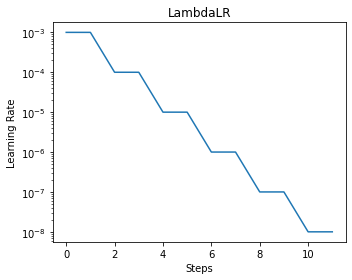

In [31]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

In [32]:
dummy_model = torch.nn.Linear(2, 1)
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=1e-3)
dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1) 

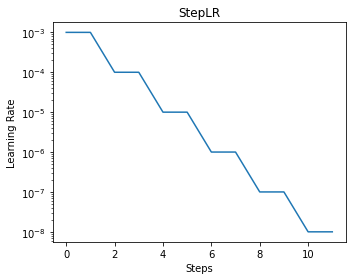

In [33]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

In [34]:
dummy_model = torch.nn.Linear(2, 1)
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=0.01)
dummy_scheduler = MultiStepLR(dummy_optimizer, milestones=[6,8,9], gamma=0.1)

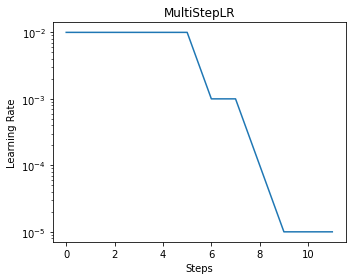

In [35]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

In [36]:
dummy_model = torch.nn.Linear(2, 1)
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=1e-3)
dummy_scheduler = ExponentialLR(dummy_optimizer, gamma=0.1)

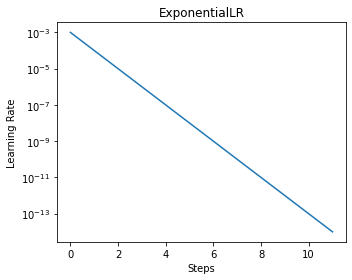

In [37]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

In [38]:
dummy_model = torch.nn.Linear(2, 1)
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=0.01)
dummy_scheduler = CosineAnnealingLR(dummy_optimizer, T_max=10, eta_min=0)

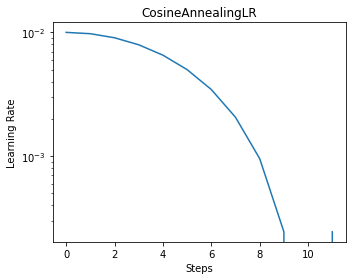

In [39]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

### Validation Loss Scheduler 

In [21]:
from torch.optim.lr_scheduler import (ReduceLROnPlateau)

In [40]:
dummy_model = torch.nn.Linear(2, 1)
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=0.01)
dummy_scheduler = ReduceLROnPlateau(dummy_optimizer, patience=4, factor=0.1)

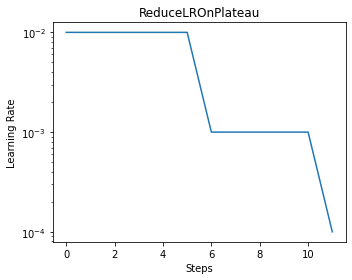

In [41]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

### Cyclical schedulers 

In [43]:
from torch.optim.lr_scheduler import CyclicLR

In [44]:
dummy_model = torch.nn.Linear(2, 1)
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=0.01)
dummy_scheduler = CyclicLR(dummy_optimizer, base_lr=0.001, max_lr=0.1,step_size_up=5,mode="triangular")

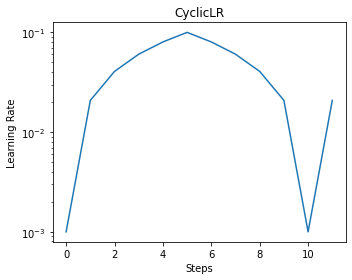

In [45]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

*** 
# Incorporate ```learning rate schedulers``` into our ```training loop``` - ([ref](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/Chapter06.ipynb))
* How to add ```schedulers``` into our ```D2torchEngine``` class ?
* Since schedulers are definitely
optional, we need to add a method to allow the user to set a scheduler
* p.545

In [46]:
setattr(D2torchEngine, 'scheduler', None)
setattr(D2torchEngine, 'is_batch_lr_scheduler', False)

In [ ]:
def set_lr_scheduler(self, scheduler): 
    
    if scheduler.optimzier == self.optimzier:
        